In [2]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = (10, 10)
blue = (43, 156, 212)
red = (212, 100, 100)
orange = (249, 182, 118)
green = (43, 212, 156)

In [4]:
paths = ['dice1.jpg', 'dice2.jpg', 'dice4.jpg']

In [71]:
results = []
for i, path in enumerate(paths):
    img = cv2.imread('../imgs/{}'.format(path))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(img_gray, (200, 200))
    blurred = cv2.blur(resized, (10, 10))
    retval, threshold = cv2.threshold(blurred, 120, 255, cv2.THRESH_BINARY)
#     eroded = cv2.erode(threshold, (1, 1), iterations = 1)
    eroded = threshold
    threshold, contours, hierarchy = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#     cv2.drawContours(img, contours, -1, orange, cv2.LINE_AA)
    
    for c, contour in enumerate(contours):
        sub_results = []
        # dice min area (rotated rect)
        rect_min_area = cv2.minAreaRect(contour)
        rect_min_points = cv2.boxPoints(rect_min_area)
        rect_min_box = np.int0(rect_min_points)
        cv2.drawContours(img, [rect_min_box], 0, red, cv2.LINE_AA)
        sub_results.append(img)
        
        # bounding rect of the *min area rect*
        rrb = cv2.boundingRect(rect_min_points)
        rrb_tl = rrb[0:2]
        rrb_br = tuple([sum(x) for x in zip(rrb_tl, rrb[2:4])])
        cv2.rectangle(img, rrb_tl, rrb_br, blue, 3, cv2.LINE_AA)
        
        y_start = min(max(0, rrb_tl[1]), img.shape[1])
        y_end =   min(max(0, rrb_br[1]), img.shape[1])
        
        x_start = min(max(0, rrb_tl[0]), img.shape[0])
        x_end =   min(max(0, rrb_br[0]), img.shape[0])

        cropped = eroded[y_start:y_end, x_start:x_end]        
        sub_results.append(cropped)

        rect_min_width = int(rect_min_area[1][0] - rect_min_area[0][0])
        rect_min_height = int(rect_min_area[1][1] - rect_min_area[0][1])
        
        keep = rect_min_area[2] > -45
        width = int(rect_min_area[1][0 if keep else 1])
        height = int(rect_min_area[1][1 if keep else 0])
        angle = rect_min_area[2] + (0 if keep else 90)
        center = (width / 2, height / 2)
        
        dsize = (width * 2, height * 2)    
        matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        straight = cv2.warpAffine(cropped, matrix, dsize)
        sub_results.append(straight)
        
        straight_col = cv2.cvtColor(straight, cv2.COLOR_GRAY2BGR)
        t, cc, h = cv2.findContours(straight, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        
        biggest = max(cc, key=lambda c: cv2.contourArea(c))
        
        bb = cv2.boundingRect(biggest)
        straight_crop = straight[
            bb[1]:bb[1] + bb[3],
            bb[0]:bb[0] + bb[2]
        ]
        cv2.drawContours(straight_col, cc, -1, orange, cv2.LINE_AA)
        sub_results.append(straight_col)
        
        filename = 'output/{}-{}.png'.format(path, str(c).zfill(2))
        cv2.imwrite(filename, straight_crop)
        print('wrote to {}'.format(filename))
        sub_results.append(straight_crop)
        
        results.append(sub_results)
                

wrote to output/dice1.jpg-00.png
wrote to output/dice1.jpg-01.png
wrote to output/dice2.jpg-00.png
wrote to output/dice4.jpg-00.png


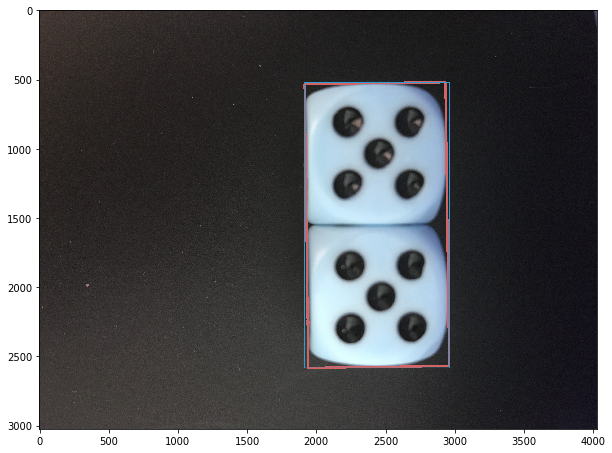

In [51]:
plt.imshow(results[4][0], 'gray')